In [28]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold, TimeSeriesSplit, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_recall_curve, matthews_corrcoef, f1_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

In [4]:
feature_groups = {
    "process_complexity": ['log_churn', 'dmm_unit_size', 'dmm_unit_complexity'],
    "temporal_behavior": ['time_diff', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos'],
    "textual_intent": ['msg_len', 'has_fix_word']
}
feature_cols = [
    'log_churn',
    'dmm_unit_size',
    'dmm_unit_complexity',
    'time_diff',
    'msg_len',
    'has_fix_word',
    'weekday_sin', 'weekday_cos',
    'hour_sin', 'hour_cos'
]
id_cols = ['hash', 'repo_url', 'author_date']

In [32]:
df = pd.read_csv('../data/data/processed/icvul_features_final.csv')
print("Shape:", df.shape)
X = df[feature_cols]
y = df['label']
groups_repo = df['repo_url']
print("Missing per-feature:\n", X.isna().sum())

Shape: (8690, 14)
Missing per-feature:
 log_churn              0
dmm_unit_size          0
dmm_unit_complexity    0
time_diff              0
msg_len                0
has_fix_word           0
weekday_sin            0
weekday_cos            0
hour_sin               0
hour_cos               0
dtype: int64


In [20]:
def make_stratified_split(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

def make_temporal_split(df, feature_cols, label_col='label', fraction_train=0.8):
    df_sorted = df.sort_values("author_date").reset_index(drop=True)
    split_idx = int(fraction_train * len(df_sorted))
    train = df_sorted.iloc[:split_idx]
    test  = df_sorted.iloc[split_idx:]
    X_tr, y_tr = train[feature_cols], train[label_col]
    X_te, y_te = test[feature_cols], test[label_col]
    return X_tr, X_te, y_tr, y_te, df_sorted

# create both splits
X_train_rand, X_test_rand, y_train_rand, y_test_rand = make_stratified_split(X, y)
X_train_temp, X_test_temp, y_train_temp, y_test_temp, df_sorted = make_temporal_split(df, feature_cols)
w_train_rand  = compute_sample_weight('balanced', y_train_rand)
w_train_temp  = compute_sample_weight('balanced', y_train_temp)
print("Random split sizes:", X_train_rand.shape[0], X_test_rand.shape[0])
print("Temporal split sizes:", X_train_temp.shape[0], X_test_temp.shape[0])
print("Class distribution in temporal test set:\n", y_test_temp.value_counts(normalize=True))
print("Class distribution in random test set:\n", y_test_rand.value_counts(normalize=True))

Random split sizes: 6952 1738
Temporal split sizes: 6952 1738
Class distribution in temporal test set:
 label
0    0.602417
1    0.397583
Name: proportion, dtype: float64
Class distribution in random test set:
 label
1    0.670886
0    0.329114
Name: proportion, dtype: float64


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

X_vif = X.copy()

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

               Feature       VIF
1        dmm_unit_size  1.643720
2  dmm_unit_complexity  1.642255
5         has_fix_word  1.308468
9             hour_cos  1.136235
0            log_churn  1.122351
8             hour_sin  1.114245
6          weekday_sin  1.074760
4              msg_len  1.023459
3            time_diff  1.013784
7          weekday_cos  1.002542


In [8]:
corr_label = df[feature_cols + ['label']].corr()['label'].sort_values(ascending=False)
print(corr_label)


label                  1.000000
log_churn              0.522567
dmm_unit_size          0.132024
dmm_unit_complexity    0.109827
hour_cos               0.092922
msg_len                0.010839
weekday_sin           -0.011977
weekday_cos           -0.023410
hour_sin              -0.029680
time_diff             -0.095136
has_fix_word          -0.394903
Name: label, dtype: float64


In [9]:
def evaluate_on_holdout(pipeline, X_test, y_test, name="model"):
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    print(f"\n{name} — Holdout metrics")
    print(f"ROC-AUC: {roc:.4f}   PR-AUC (AP): {pr:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    RocCurveDisplay.from_predictions(y_test, y_prob); plt.title(f"{name} — ROC"); plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues"); plt.title(f"{name} — Confusion"); plt.show()
    return {"roc_auc": roc, "pr_auc": pr, "y_prob": y_prob, "y_pred": y_pred}


In [37]:
def best_f1_threshold(y_true, y_prob):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*p*r/(p+r+1e-12)
    idx = np.argmax(f1[:-1])
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1[idx])

def evaluate_single_set(y_true, y_prob, name="LR", threshold=0.5, show=True):
    y_pred = (y_prob >= threshold).astype(int)
    roc = roc_auc_score(y_true, y_prob)
    ap  = average_precision_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    if show:
        print(f"\n{name} — metrics @ t={threshold:.3f} | ROC-AUC={roc:.4f}  PR-AUC={ap:.4f}  MCC={mcc:.4f}  κ={kappa:.4f}")
        print(classification_report(y_true, y_pred, digits=4))
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")
        plt.title(f"{name} — Confusion (t={threshold:.3f})"); plt.show()
        CalibrationDisplay.from_predictions(y_true, y_prob, n_bins=10)
        plt.title(f"{name} — Calibration"); plt.show()
    return {"roc_auc":roc, "pr_auc":ap, "mcc":mcc, "kappa":kappa}

def evaluate_train_test(pipeline, X_tr, y_tr, X_te, y_te, name="LR", sample_weight=None):
    # fit
    fit_kwargs = {}
    if sample_weight is not None:
        # name is 'logisticregression' inside make_pipeline(StandardScaler(), LogisticRegression(...))
        fit_kwargs["logisticregression__sample_weight"] = sample_weight
    pipeline.fit(X_tr, y_tr, **fit_kwargs)

    # probabilities
    p_tr = pipeline.predict_proba(X_tr)[:,1]
    p_te = pipeline.predict_proba(X_te)[:,1]

    # overlay ROC + PR (train vs test)
    RocCurveDisplay.from_predictions(y_tr, p_tr, name="Train")
    RocCurveDisplay.from_predictions(y_te, p_te, name="Test", ax=plt.gca())
    plt.title(f"{name} — ROC (Train vs Test)"); plt.show()

    PrecisionRecallDisplay.from_predictions(y_tr, p_tr, name="Train")
    PrecisionRecallDisplay.from_predictions(y_te, p_te, name="Test", ax=plt.gca())
    plt.title(f"{name} — PR (Train vs Test)"); plt.show()

    # default threshold 0.5 on test
    res_test_05 = evaluate_single_set(y_te, p_te, f"{name} — Test", threshold=0.5, show=True)

    # tune threshold on TRAIN for best-F1, then evaluate both sets at that threshold
    thr, P, R, F1 = best_f1_threshold(y_tr, p_tr)
    print(f"{name}: best-F1 on TRAIN → t={thr:.3f}, Precision={P:.3f}, Recall={R:.3f}, F1={F1:.3f}")

    res_train_tuned = evaluate_single_set(y_tr, p_tr, f"{name} — Train", threshold=thr, show=True)
    res_test_tuned  = evaluate_single_set(y_te, p_te, f"{name} — Test", threshold=thr, show=True)

    return {
        "thr_train_bestF1": thr,
        "train": {"@0.5": evaluate_single_set(y_tr, p_tr, show=False),
                  "@bestF1": res_train_tuned},
        "test":  {"@0.5": res_test_05,
                  "@bestF1": res_test_tuned},
        "proba": {"train": p_tr, "test": p_te},
        "fitted_model": pipeline
    }


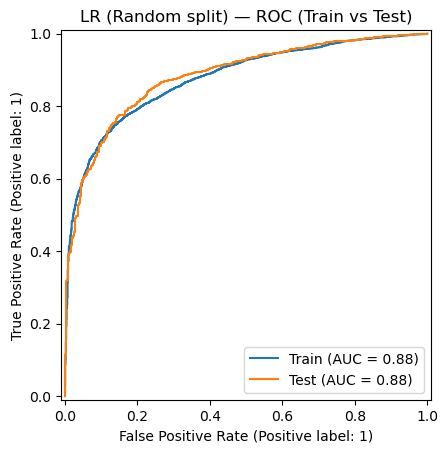

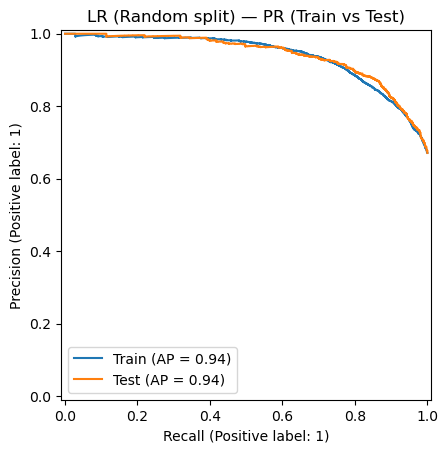


LR (Random split) — Test — metrics @ t=0.500 | ROC-AUC=0.8832  PR-AUC=0.9414  MCC=0.5892  κ=0.5785
              precision    recall  f1-score   support

           0     0.6552    0.8339    0.7338       572
           1     0.9059    0.7847    0.8410      1166

    accuracy                         0.8009      1738
   macro avg     0.7806    0.8093    0.7874      1738
weighted avg     0.8234    0.8009    0.8057      1738



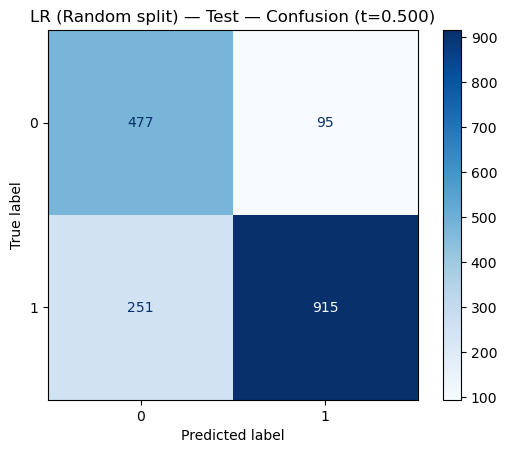

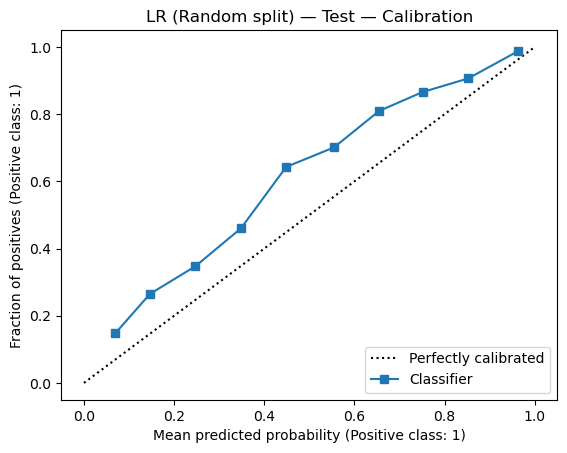

LR (Random split): best-F1 on TRAIN → t=0.253, Precision=0.810, Recall=0.907, F1=0.856

LR (Random split) — Train — metrics @ t=0.253 | ROC-AUC=0.8769  PR-AUC=0.9389  MCC=0.5146  κ=0.5049
              precision    recall  f1-score   support

           0     0.7490    0.5665    0.6451      2286
           1     0.8103    0.9070    0.8559      4666

    accuracy                         0.7950      6952
   macro avg     0.7796    0.7367    0.7505      6952
weighted avg     0.7901    0.7950    0.7866      6952



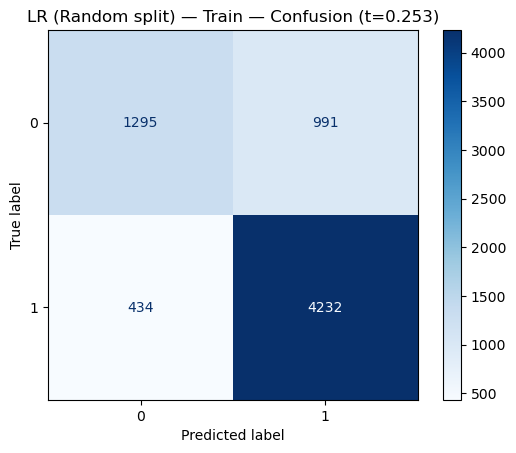

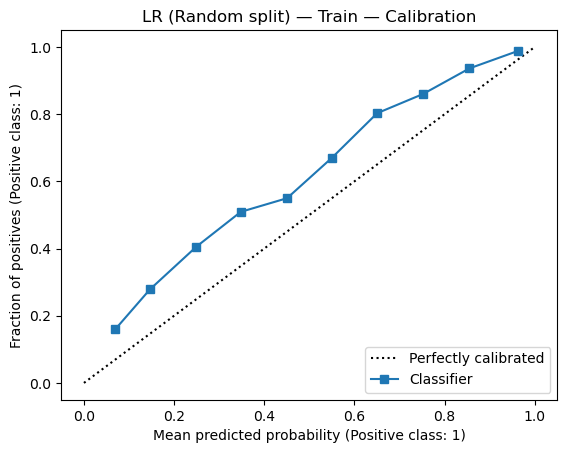


LR (Random split) — Test — metrics @ t=0.253 | ROC-AUC=0.8832  PR-AUC=0.9414  MCC=0.5295  κ=0.5197
              precision    recall  f1-score   support

           0     0.7604    0.5769    0.6561       572
           1     0.8144    0.9108    0.8599      1166

    accuracy                         0.8009      1738
   macro avg     0.7874    0.7439    0.7580      1738
weighted avg     0.7966    0.8009    0.7928      1738



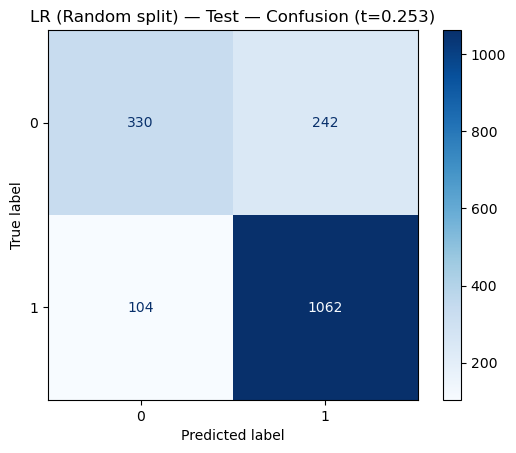

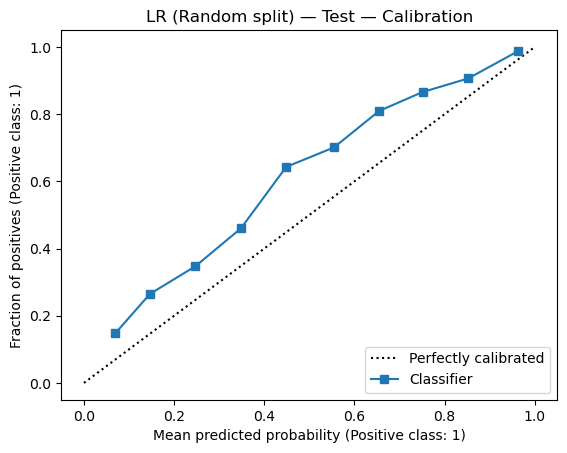

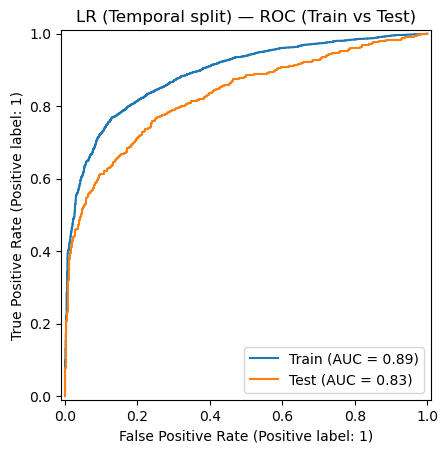

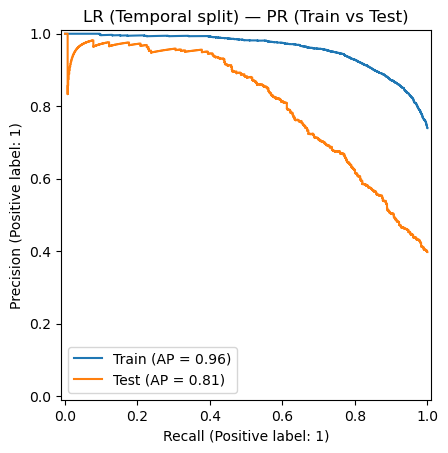


LR (Temporal split) — Test — metrics @ t=0.500 | ROC-AUC=0.8296  PR-AUC=0.8057  MCC=0.5088  κ=0.5086
              precision    recall  f1-score   support

           0     0.8093    0.7947    0.8019      1047
           1     0.6972    0.7164    0.7066       691

    accuracy                         0.7635      1738
   macro avg     0.7533    0.7555    0.7543      1738
weighted avg     0.7647    0.7635    0.7640      1738



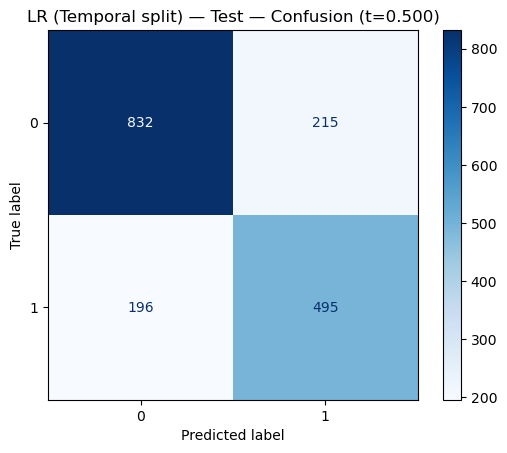

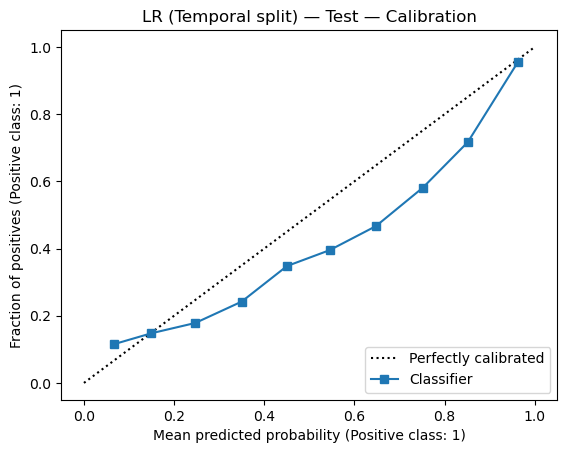

LR (Temporal split): best-F1 on TRAIN → t=0.201, Precision=0.849, Recall=0.935, F1=0.890

LR (Temporal split) — Train — metrics @ t=0.201 | ROC-AUC=0.8899  PR-AUC=0.9589  MCC=0.5243  κ=0.5121
              precision    recall  f1-score   support

           0     0.7426    0.5290    0.6179      1811
           1     0.8493    0.9354    0.8903      5141

    accuracy                         0.8295      6952
   macro avg     0.7960    0.7322    0.7541      6952
weighted avg     0.8215    0.8295    0.8193      6952



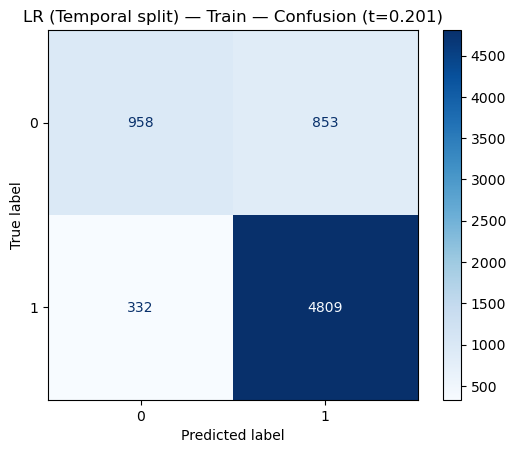

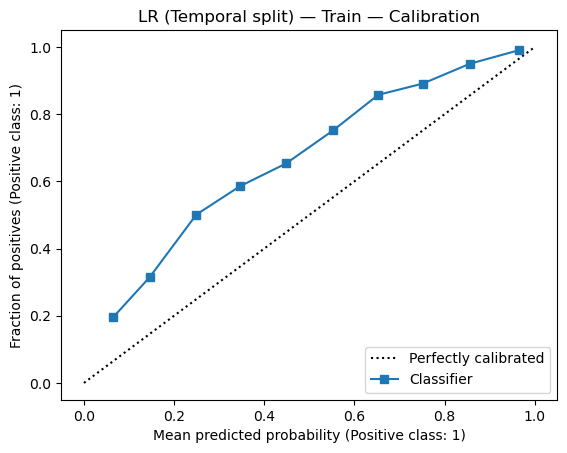


LR (Temporal split) — Test — metrics @ t=0.201 | ROC-AUC=0.8296  PR-AUC=0.8057  MCC=0.3409  κ=0.2761
              precision    recall  f1-score   support

           0     0.8679    0.4078    0.5549      1047
           1     0.5024    0.9059    0.6464       691

    accuracy                         0.6059      1738
   macro avg     0.6851    0.6569    0.6006      1738
weighted avg     0.7226    0.6059    0.5913      1738



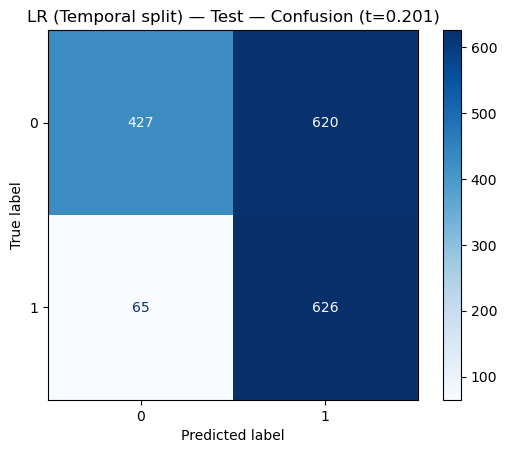

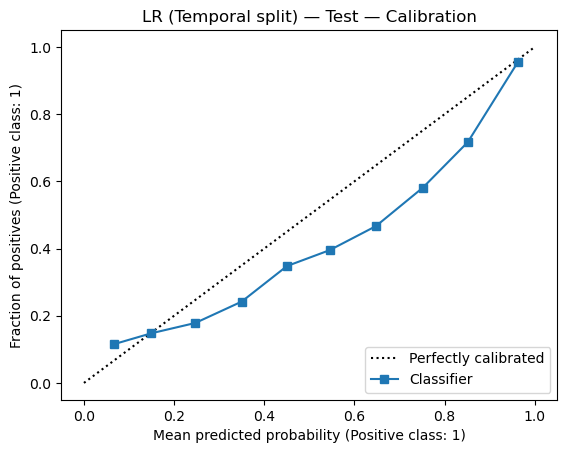

In [38]:
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=10000, solver='lbfgs', class_weight='balanced', random_state=42)
)

res_lr_rand = evaluate_train_test(
    pipe_lr, X_train_rand, y_train_rand, X_test_rand, y_test_rand,
    name="LR (Random split)", sample_weight=w_train_rand
)

res_lr_temp = evaluate_train_test(
    pipe_lr, X_train_temp, y_train_temp, X_test_temp, y_test_temp,
    name="LR (Temporal split)", sample_weight=w_train_temp
)


Best params: {'logisticregression__C': 0.1}   best CV AP: 0.9575096010565562


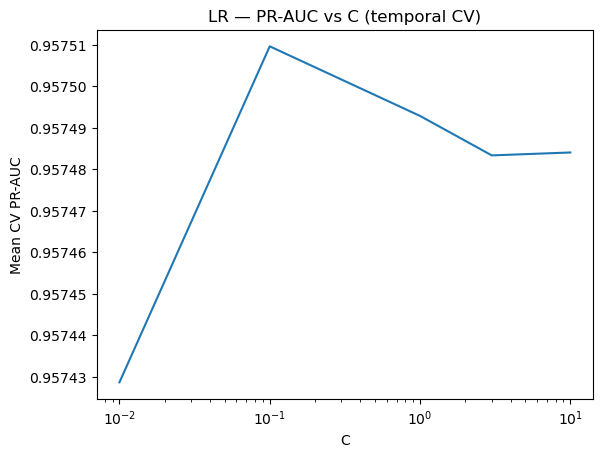

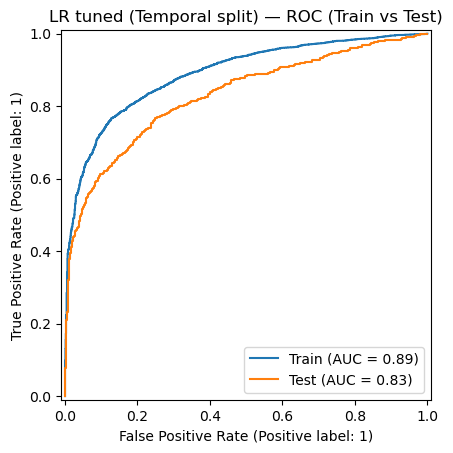

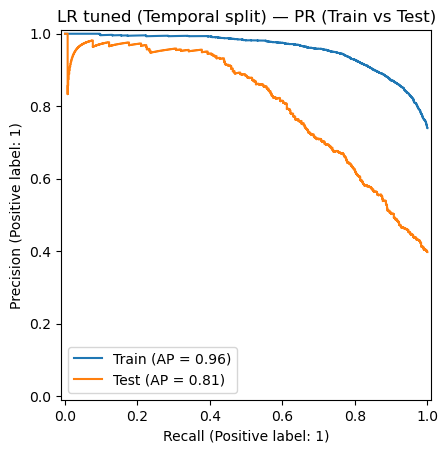


LR tuned (Temporal split) — Test — metrics @ t=0.500 | ROC-AUC=0.8297  PR-AUC=0.8058  MCC=0.5119  κ=0.5119
              precision    recall  f1-score   support

           0     0.8099    0.7975    0.8037      1047
           1     0.7001    0.7164    0.7082       691

    accuracy                         0.7652      1738
   macro avg     0.7550    0.7569    0.7559      1738
weighted avg     0.7663    0.7652    0.7657      1738



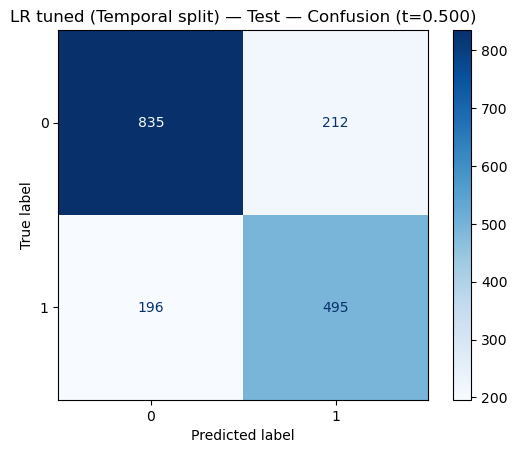

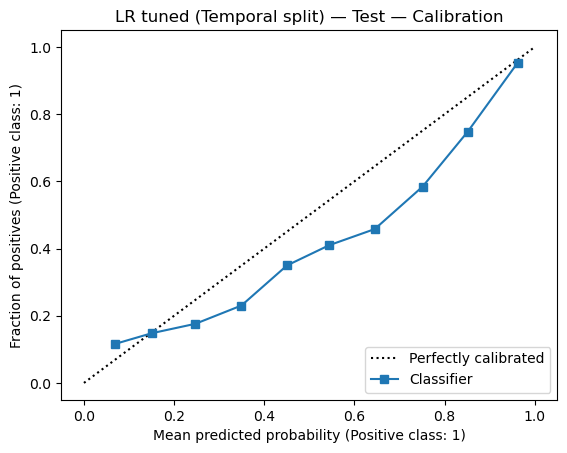

LR tuned (Temporal split): best-F1 on TRAIN → t=0.213, Precision=0.852, Recall=0.933, F1=0.890

LR tuned (Temporal split) — Train — metrics @ t=0.213 | ROC-AUC=0.8899  PR-AUC=0.9589  MCC=0.5275  κ=0.5168
              precision    recall  f1-score   support

           0     0.7383    0.5389    0.6230      1811
           1     0.8517    0.9327    0.8904      5141

    accuracy                         0.8301      6952
   macro avg     0.7950    0.7358    0.7567      6952
weighted avg     0.8221    0.8301    0.8207      6952



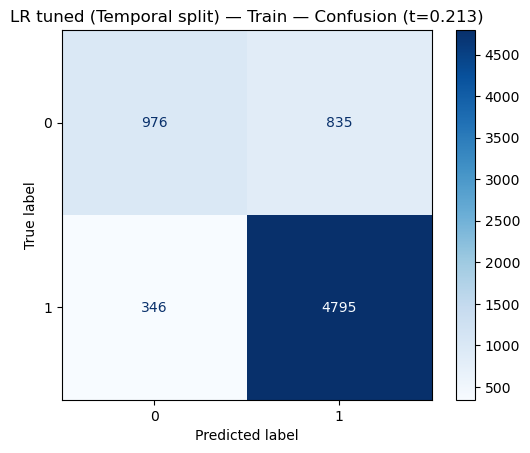

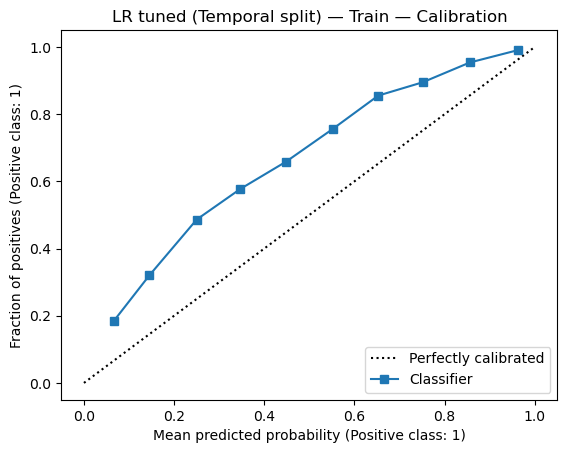


LR tuned (Temporal split) — Test — metrics @ t=0.213 | ROC-AUC=0.8297  PR-AUC=0.8058  MCC=0.3462  κ=0.2848
              precision    recall  f1-score   support

           0     0.8650    0.4222    0.5674      1047
           1     0.5069    0.9001    0.6486       691

    accuracy                         0.6122      1738
   macro avg     0.6859    0.6612    0.6080      1738
weighted avg     0.7226    0.6122    0.5997      1738



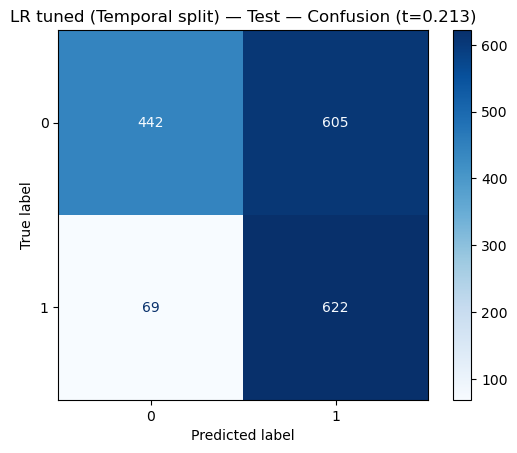

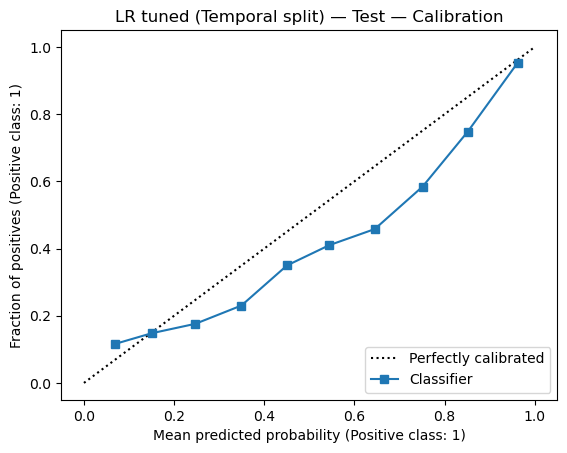

In [39]:
grid = GridSearchCV(
    estimator=pipe_lr,
    param_grid={"logisticregression__C":[0.01,0.1,1,3,10]},
    scoring="average_precision", cv=5, n_jobs=-1, refit=True
)
grid.fit(X_train_temp, y_train_temp, logisticregression__sample_weight=w_train_temp)
print("Best params:", grid.best_params_, "  best CV AP:", grid.best_score_)

cv = pd.DataFrame(grid.cv_results_)
sns.lineplot(x=cv["param_logisticregression__C"].astype(float), y=cv["mean_test_score"])
plt.xscale("log"); plt.xlabel("C"); plt.ylabel("Mean CV PR-AUC"); plt.title("LR — PR-AUC vs C (temporal CV)"); plt.show()

best_lr = grid.best_estimator_
res_lr_temp_tuned = evaluate_train_test(
    best_lr, X_train_temp, y_train_temp, X_test_temp, y_test_temp,
    name="LR tuned (Temporal split)", sample_weight=w_train_temp
)


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/calibration.py:383: UserWarning: Since Pipeline does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(


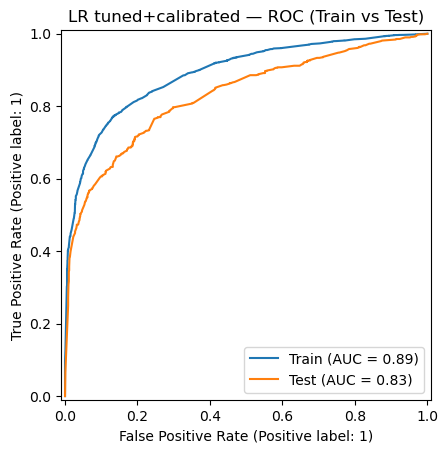

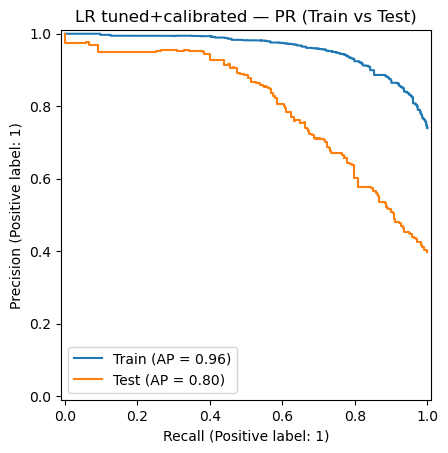

Calibrated: best-F1 on TRAIN → t=0.254, P=0.863, R=0.920, F1=0.891

LR tuned+calibrated — Test — metrics @ t=0.500 | ROC-AUC=0.8299  PR-AUC=0.8021  MCC=0.5126  κ=0.5122
              precision    recall  f1-score   support

           0     0.7987    0.8223    0.8104      1047
           1     0.7182    0.6860    0.7017       691

    accuracy                         0.7681      1738
   macro avg     0.7584    0.7542    0.7560      1738
weighted avg     0.7667    0.7681    0.7672      1738



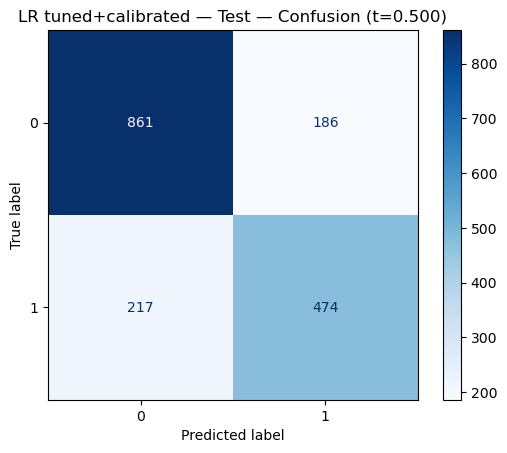

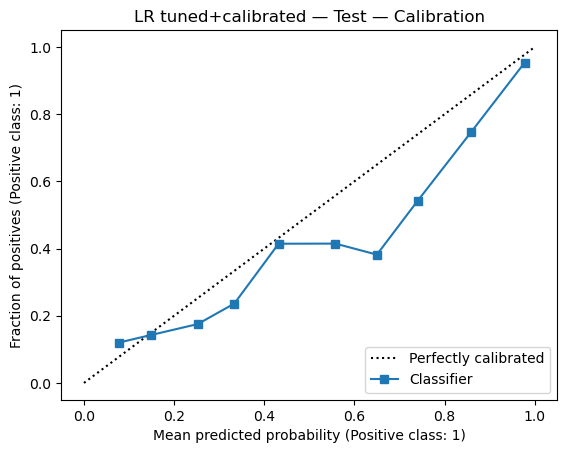


LR tuned+calibrated — Test — metrics @ t=0.254 | ROC-AUC=0.8299  PR-AUC=0.8021  MCC=0.3788  κ=0.3276
              precision    recall  f1-score   support

           0     0.8640    0.4795    0.6167      1047
           1     0.5290    0.8857    0.6623       691

    accuracy                         0.6410      1738
   macro avg     0.6965    0.6826    0.6395      1738
weighted avg     0.7308    0.6410    0.6348      1738



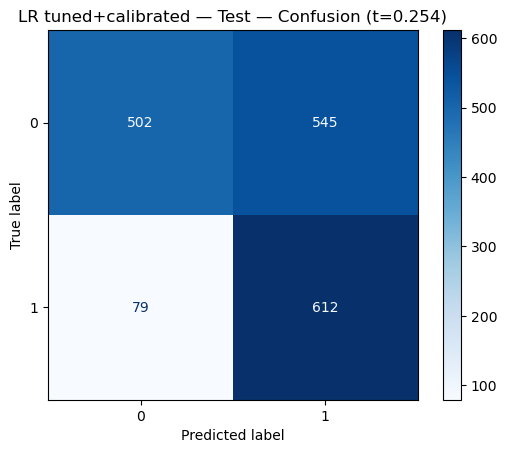

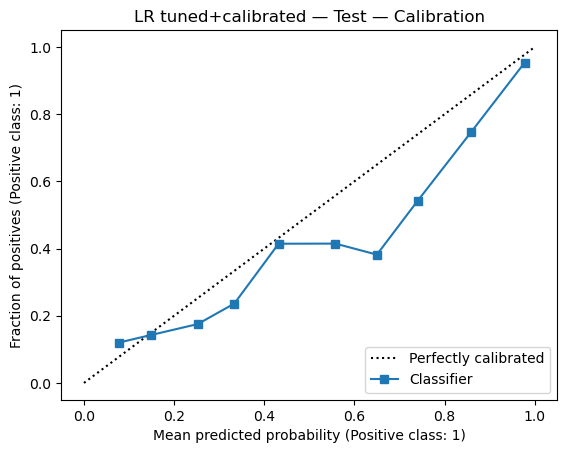

In [40]:
cal = CalibratedClassifierCV(best_lr, method="isotonic", cv=5)
cal.fit(X_train_temp, y_train_temp, sample_weight=w_train_temp)

pipe_cal = cal 
p_tr_cal = pipe_cal.predict_proba(X_train_temp)[:,1]
p_te_cal = pipe_cal.predict_proba(X_test_temp)[:,1]
RocCurveDisplay.from_predictions(y_train_temp, p_tr_cal, name="Train")
RocCurveDisplay.from_predictions(y_test_temp, p_te_cal, name="Test", ax=plt.gca())
plt.title("LR tuned+calibrated — ROC (Train vs Test)"); plt.show()
PrecisionRecallDisplay.from_predictions(y_train_temp, p_tr_cal, name="Train")
PrecisionRecallDisplay.from_predictions(y_test_temp, p_te_cal, name="Test", ax=plt.gca())
plt.title("LR tuned+calibrated — PR (Train vs Test)"); plt.show()

# Evaluate at 0.5 and at train-tuned threshold
thr_cal, P, R, F1 = best_f1_threshold(y_train_temp, p_tr_cal)
print(f"Calibrated: best-F1 on TRAIN → t={thr_cal:.3f}, P={P:.3f}, R={R:.3f}, F1={F1:.3f}")
_ = evaluate_single_set(y_test_temp, p_te_cal, "LR tuned+calibrated — Test", threshold=0.5, show=True)
_ = evaluate_single_set(y_test_temp, p_te_cal, "LR tuned+calibrated — Test", threshold=thr_cal, show=True)


In [41]:
gkf = GroupKFold(n_splits=5)
scores = cross_validate(best_lr, X, y, cv=gkf, groups=groups_repo,
                        scoring={"roc":"roc_auc","ap":"average_precision"}, n_jobs=-1)
print(pd.DataFrame({"ROC-AUC":scores['test_roc'], "PR-AUC":scores['test_ap']}).describe().T)


         count      mean       std       min       25%       50%       75%  \
ROC-AUC    5.0  0.875506  0.020045  0.857506  0.863595  0.864771  0.885827   
PR-AUC     5.0  0.938098  0.009559  0.926810  0.930039  0.939533  0.944747   

              max  
ROC-AUC  0.905832  
PR-AUC   0.949362  


In [42]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtr_std = scaler.fit_transform(X_train_temp)
Xtr_sm  = sm.add_constant(Xtr_std)
logit   = sm.Logit(y_train_temp.values, Xtr_sm)
res     = logit.fit(disp=False)
print(res.summary2())

cols = ["const"] + list(X_train_temp.columns)
pvals = pd.Series(res.pvalues, index=cols).sort_values()
print("\nSignificant (p<0.05):\n", pvals[pvals<0.05])


                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.374    
Date:               2025-10-26 17:38 AIC:              5011.9830
No. Observations:   6952             BIC:              5087.2976
Df Model:           10               Log-Likelihood:   -2495.0  
Df Residuals:       6941             LL-Null:          -3987.5  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     7.0000           Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const    2.0344     0.0540    37.6455   0.0000    1.9285    2.1404
x1       2.0363     0.0619    32.8712   0.0000    1.9149    2.1577
x2       0.0067     0.0467     0.1437   0.8857   -0.0849    0.0983
x3       0.0243     0.0456     0.5342 

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate
from sklearn.calibration import CalibratedClassifierCV


In [13]:
param_dist = {
    "max_depth": [3,4,5,6,8,10,None],
    "min_samples_split": [2,5,10,20,40,80],
    "min_samples_leaf": [1,2,5,10,20,40],
    "max_features": [None, "sqrt", "log2", 0.5],
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"]
}

In [49]:
tree_params = dict(
    criterion='gini',
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

pipe_dt = make_pipeline(StandardScaler(with_mean=False),  # keeps structure
                        DecisionTreeClassifier(**tree_params))

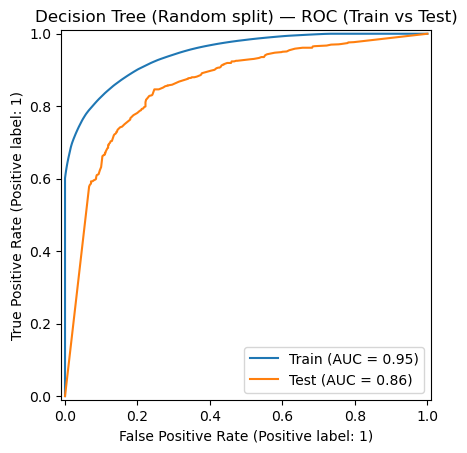

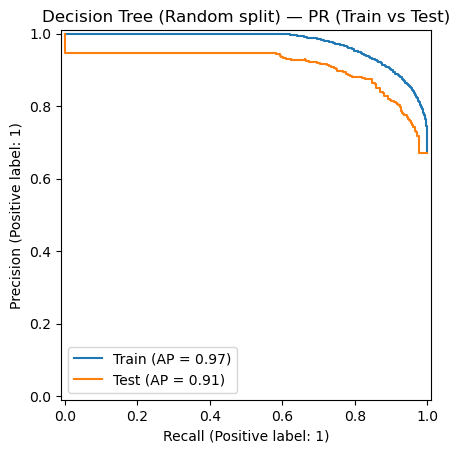


Decision Tree (Random split) — Test — metrics @ t=0.500 | ROC-AUC=0.8599  PR-AUC=0.9117  MCC=0.5577  κ=0.5462
              precision    recall  f1-score   support

           0     0.6341    0.8182    0.7145       572
           1     0.8960    0.7684    0.8273      1166

    accuracy                         0.7848      1738
   macro avg     0.7651    0.7933    0.7709      1738
weighted avg     0.8098    0.7848    0.7902      1738



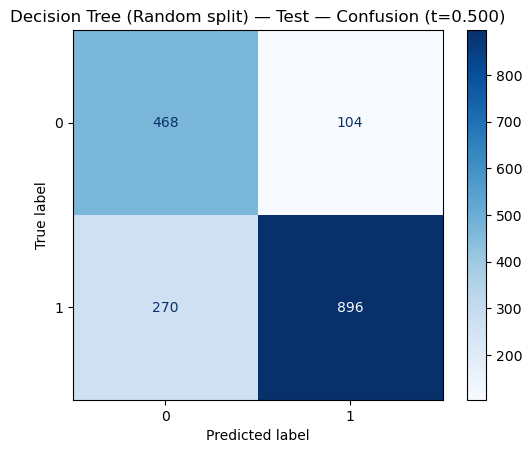

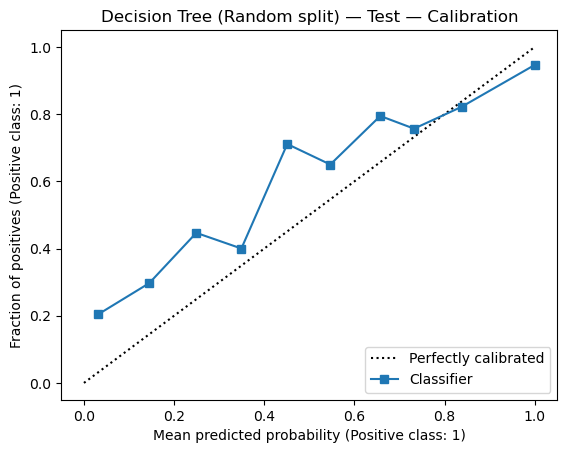

Decision Tree (Random split): best-F1 on TRAIN → t=0.290, Precision=0.881, Recall=0.928, F1=0.904

Decision Tree (Random split) — Train — metrics @ t=0.290 | ROC-AUC=0.9460  PR-AUC=0.9741  MCC=0.6927  κ=0.6902
              precision    recall  f1-score   support

           0     0.8345    0.7432    0.7862      2286
           1     0.8806    0.9278    0.9036      4666

    accuracy                         0.8671      6952
   macro avg     0.8575    0.8355    0.8449      6952
weighted avg     0.8654    0.8671    0.8650      6952



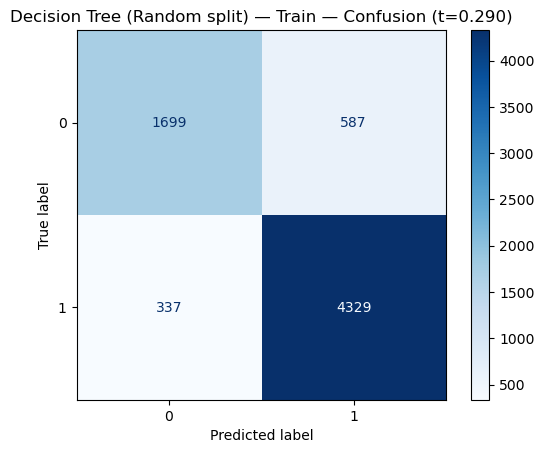

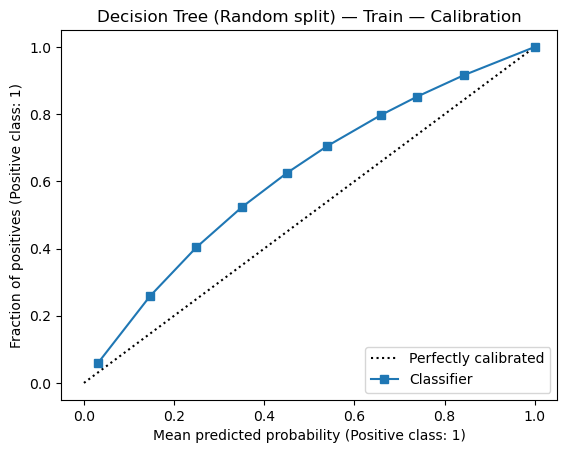


Decision Tree (Random split) — Test — metrics @ t=0.290 | ROC-AUC=0.8599  PR-AUC=0.9117  MCC=0.5451  κ=0.5433
              precision    recall  f1-score   support

           0     0.7260    0.6486    0.6851       572
           1     0.8362    0.8799    0.8575      1166

    accuracy                         0.8038      1738
   macro avg     0.7811    0.7643    0.7713      1738
weighted avg     0.7999    0.8038    0.8008      1738



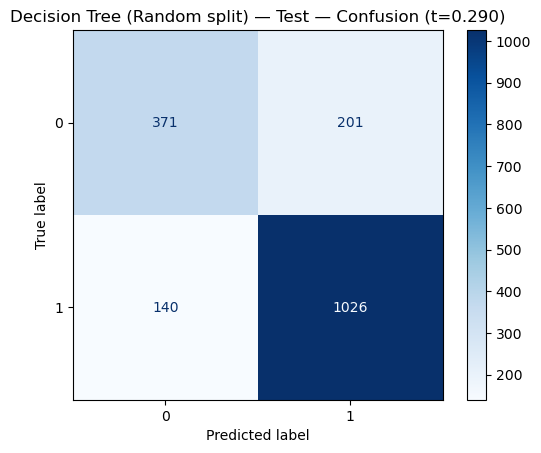

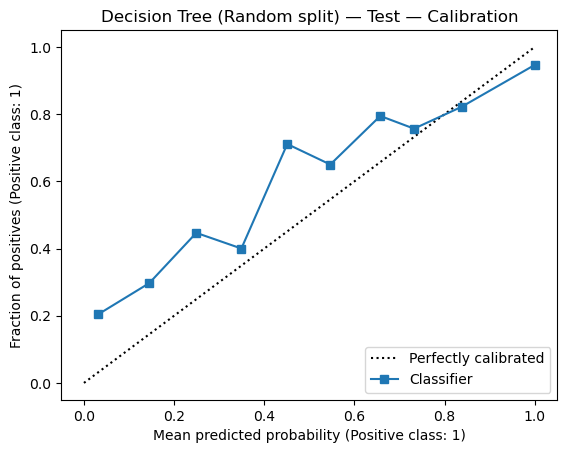

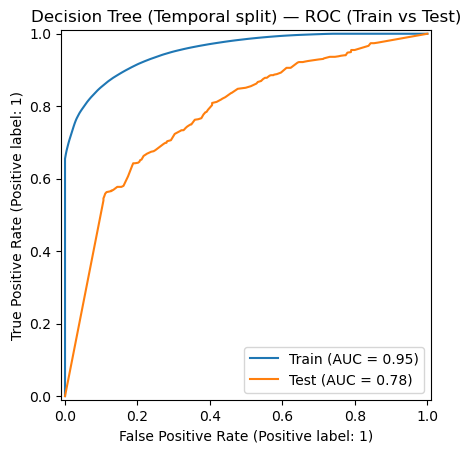

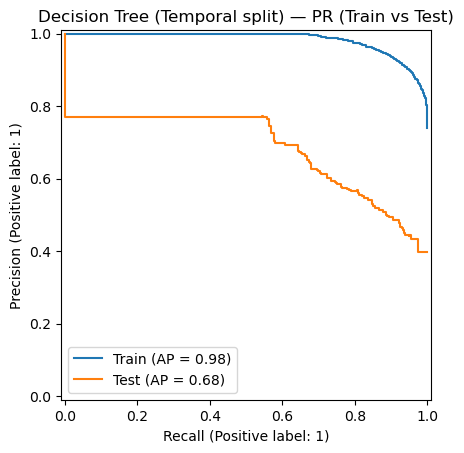


Decision Tree (Temporal split) — Test — metrics @ t=0.500 | ROC-AUC=0.7799  PR-AUC=0.6834  MCC=0.4047  κ=0.3987
              precision    recall  f1-score   support

           0     0.7940    0.6810    0.7332      1047
           1     0.6024    0.7323    0.6610       691

    accuracy                         0.7014      1738
   macro avg     0.6982    0.7066    0.6971      1738
weighted avg     0.7178    0.7014    0.7045      1738



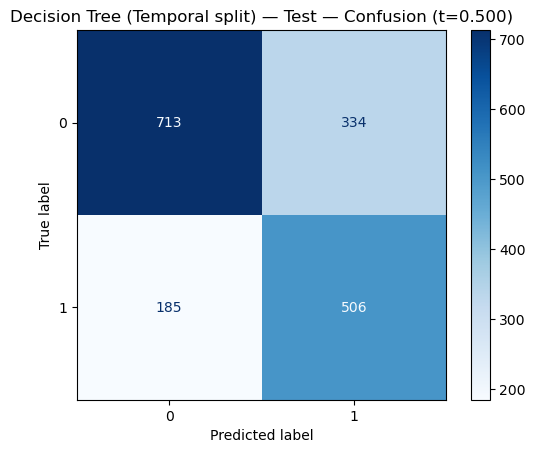

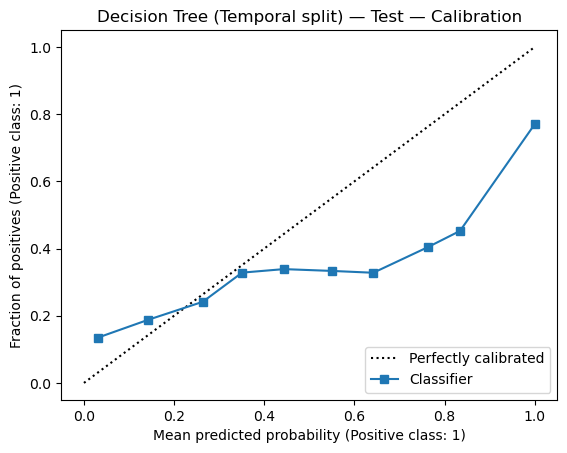

Decision Tree (Temporal split): best-F1 on TRAIN → t=0.241, Precision=0.907, Recall=0.943, F1=0.925

Decision Tree (Temporal split) — Train — metrics @ t=0.241 | ROC-AUC=0.9534  PR-AUC=0.9835  MCC=0.6976  κ=0.6954
              precision    recall  f1-score   support

           0     0.8189    0.7267    0.7700      1811
           1     0.9074    0.9434    0.9250      5141

    accuracy                         0.8869      6952
   macro avg     0.8632    0.8350    0.8475      6952
weighted avg     0.8843    0.8869    0.8847      6952



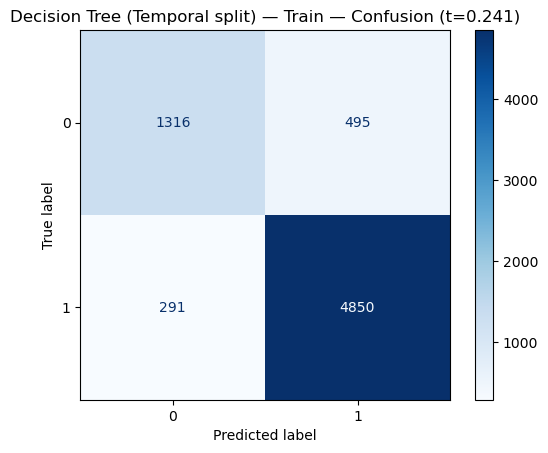

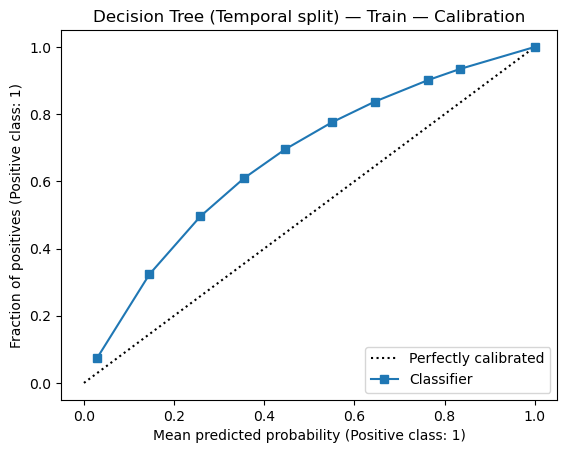


Decision Tree (Temporal split) — Test — metrics @ t=0.241 | ROC-AUC=0.7799  PR-AUC=0.6834  MCC=0.3472  κ=0.3005
              precision    recall  f1-score   support

           0     0.8419    0.4680    0.6016      1047
           1     0.5182    0.8669    0.6486       691

    accuracy                         0.6266      1738
   macro avg     0.6800    0.6674    0.6251      1738
weighted avg     0.7132    0.6266    0.6203      1738



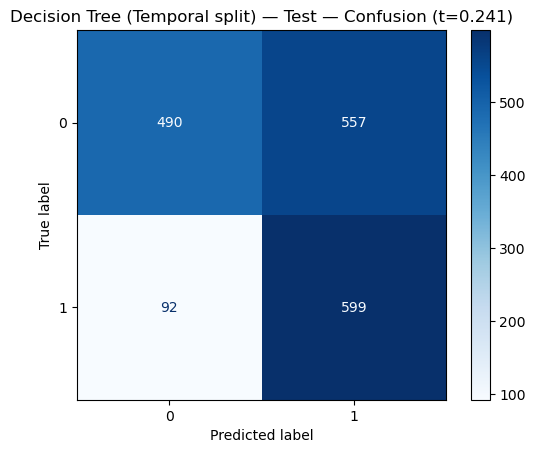

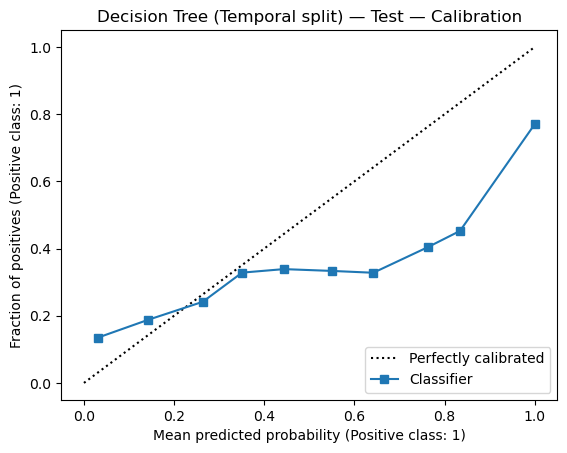

In [50]:
res_dt_rand = evaluate_train_test(
    pipe_dt, X_train_rand, y_train_rand, X_test_rand, y_test_rand,
    name="Decision Tree (Random split)"
)

res_dt_temp = evaluate_train_test(
    pipe_dt, X_train_temp, y_train_temp, X_test_temp, y_test_temp,
    name="Decision Tree (Temporal split)"
)


In [51]:
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid={
        "decisiontreeclassifier__max_depth": [5, 10, 20, None],
        "decisiontreeclassifier__min_samples_split": [2, 5, 10],
        "decisiontreeclassifier__min_samples_leaf": [1, 5, 10]
    },
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)
grid_dt.fit(X_train_temp, y_train_temp)
print("Best params:", grid_dt.best_params_, "  best CV AP:", grid_dt.best_score_)
best_dt = grid_dt.best_estimator_


Best params: {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 10, 'decisiontreeclassifier__min_samples_split': 2}   best CV AP: 0.9464066427465161


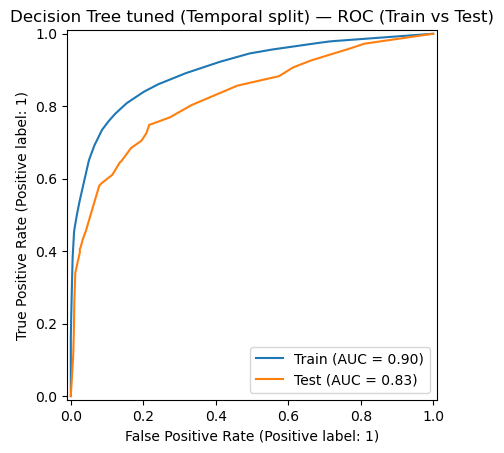

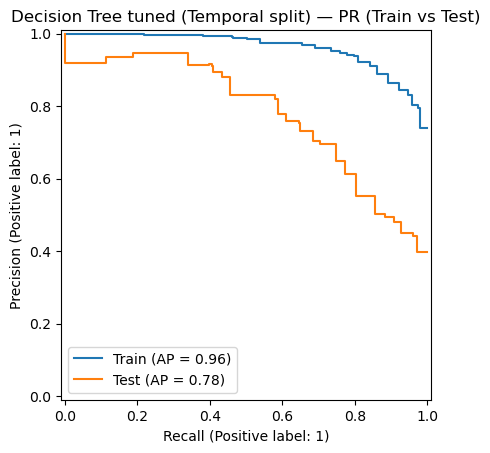


Decision Tree tuned (Temporal split) — Test — metrics @ t=0.500 | ROC-AUC=0.8255  PR-AUC=0.7793  MCC=0.5099  κ=0.5099
              precision    recall  f1-score   support

           0     0.8052    0.8052    0.8052      1047
           1     0.7048    0.7048    0.7048       691

    accuracy                         0.7652      1738
   macro avg     0.7550    0.7550    0.7550      1738
weighted avg     0.7652    0.7652    0.7652      1738



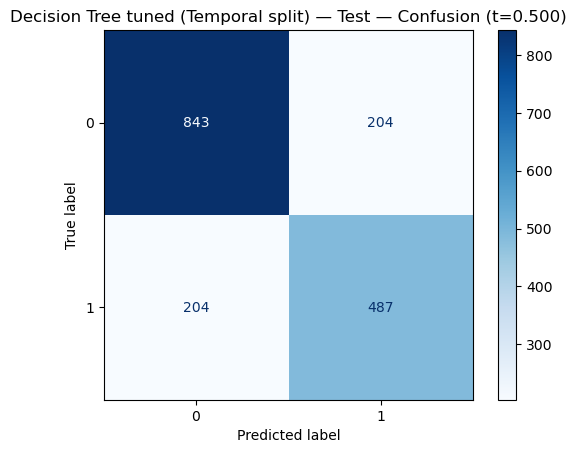

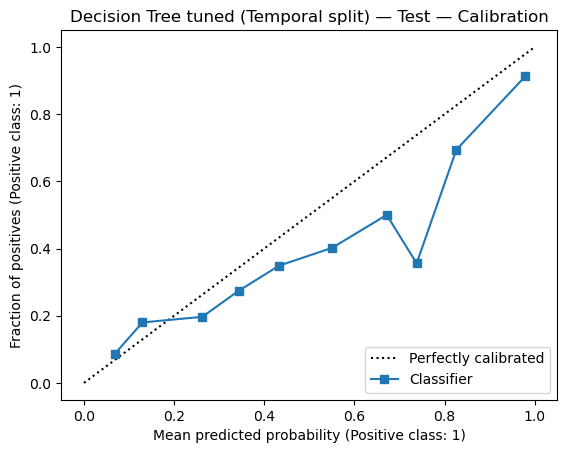

Decision Tree tuned (Temporal split): best-F1 on TRAIN → t=0.250, Precision=0.864, Recall=0.922, F1=0.892

Decision Tree tuned (Temporal split) — Train — metrics @ t=0.250 | ROC-AUC=0.9006  PR-AUC=0.9605  MCC=0.5504  κ=0.5452
              precision    recall  f1-score   support

           0     0.7278    0.5892    0.6512      1811
           1     0.8644    0.9224    0.8924      5141

    accuracy                         0.8356      6952
   macro avg     0.7961    0.7558    0.7718      6952
weighted avg     0.8288    0.8356    0.8296      6952



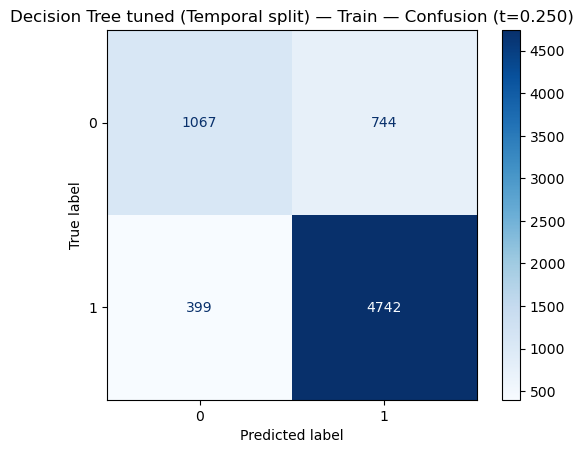

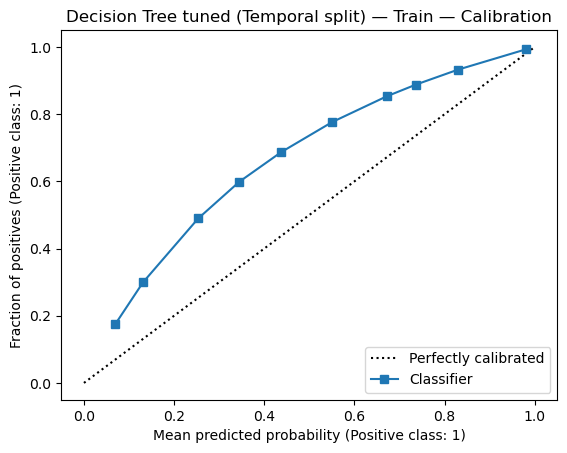


Decision Tree tuned (Temporal split) — Test — metrics @ t=0.250 | ROC-AUC=0.8255  PR-AUC=0.7793  MCC=0.3287  κ=0.2737
              precision    recall  f1-score   support

           0     0.8463    0.4260    0.5667      1047
           1     0.5037    0.8828    0.6414       691

    accuracy                         0.6076      1738
   macro avg     0.6750    0.6544    0.6041      1738
weighted avg     0.7101    0.6076    0.5964      1738



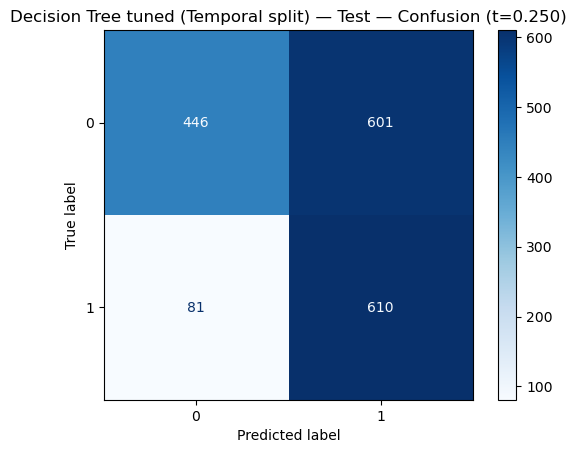

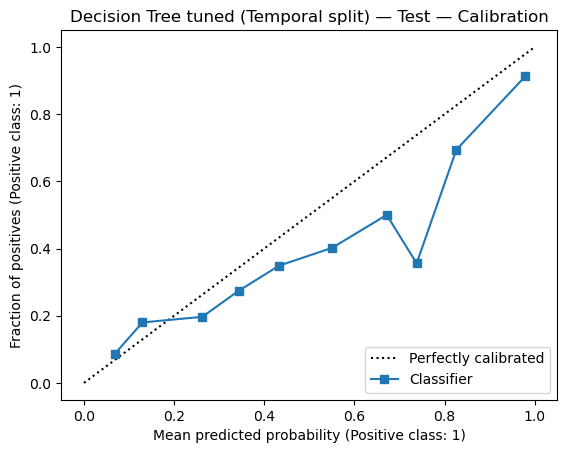

In [52]:
res_dt_temp_tuned = evaluate_train_test(
    best_dt, X_train_temp, y_train_temp, X_test_temp, y_test_temp,
    name="Decision Tree tuned (Temporal split)"
)

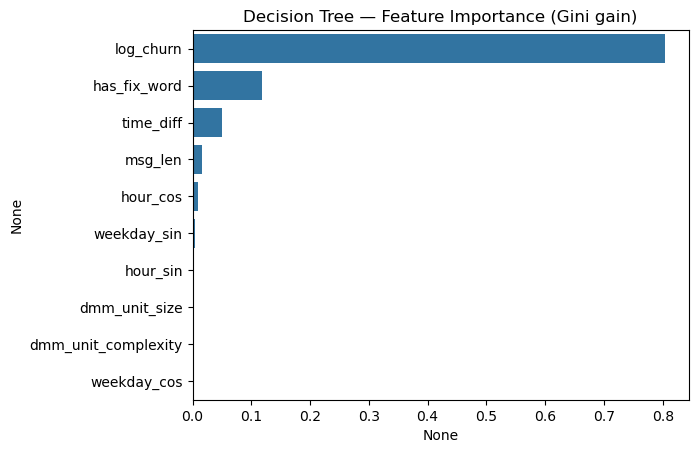

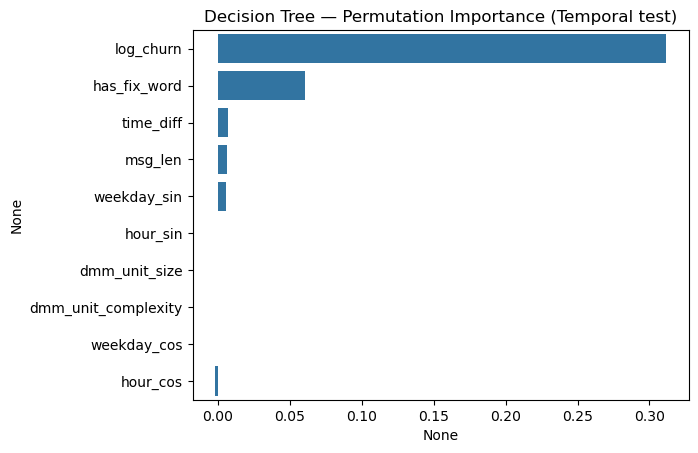

In [53]:
model = best_dt.named_steps['decisiontreeclassifier']

# 1) Static (Gini / entropy)
imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=imp, y=imp.index)
plt.title("Decision Tree — Feature Importance (Gini gain)")
plt.show()

# 2) Permutation importance
perm = permutation_importance(best_dt, X_test_temp, y_test_temp,
                              n_repeats=20, random_state=42, scoring="average_precision")
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
sns.barplot(x=perm_imp, y=perm_imp.index)
plt.title("Decision Tree — Permutation Importance (Temporal test)")
plt.show()


In [54]:
model = best_dt.named_steps['decisiontreeclassifier']
print(f"Tree depth: {model.get_depth()} | Leaves: {model.get_n_leaves()}")


Tree depth: 5 | Leaves: 31


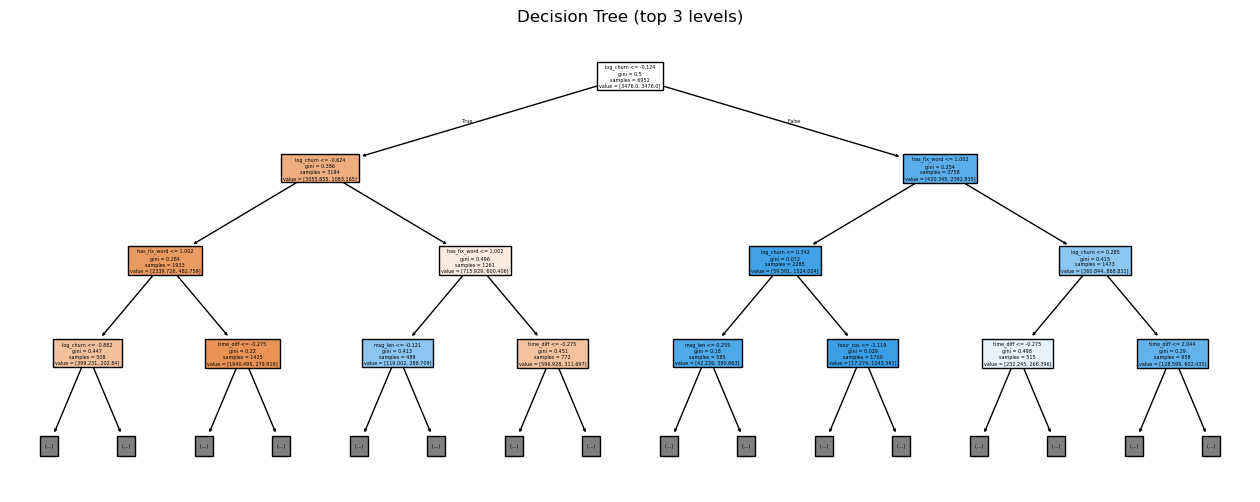

In [57]:
plt.figure(figsize=(16,6))
plot_tree(model, feature_names=X.columns, filled=True, max_depth=3)
plt.title("Decision Tree (top 3 levels)")
plt.show()


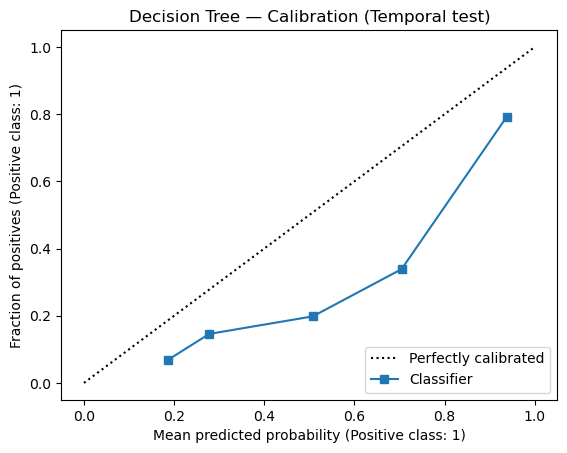

In [58]:
cal_dt = CalibratedClassifierCV(best_dt, method="isotonic", cv=5)
cal_dt.fit(X_train_temp, y_train_temp)
p_te_cal_dt = cal_dt.predict_proba(X_test_temp)[:,1]
CalibrationDisplay.from_predictions(y_test_temp, p_te_cal_dt)
plt.title("Decision Tree — Calibration (Temporal test)")
plt.show()


In [ ]:
summary_rows_dt = [
    summarize_run("DT (Random split, baseline)", res_dt_rand),
    summarize_run("DT (Temporal split, baseline)", res_dt_temp),
    summarize_run("DT (Temporal split, tuned)", res_dt_temp_tuned)
]
summary_df_dt = pd.DataFrame(summary_rows_dt)
display(summary_df_dt)


,run,thr_train_bestF1,train_ROC@0.5,train_AP@0.5,train_ROC@bestF1,train_AP@bestF1,test_ROC@0.5,test_AP@0.5,test_ROC@bestF1,test_AP@bestF1,test_MCC@bestF1,test_kappa@bestF1
0,"DT (Random split, baseline)",0.289910,0.945990,0.974079,0.945990,0.974079,0.859928,0.911663,0.859928,0.911663,0.545113,0.543291
1,"DT (Temporal split, baseline)",0.240721,0.953390,0.983476,0.953390,0.983476,0.779881,0.683377,0.779881,0.683377,0.347248,0.300486
2,"DT (Temporal split, tuned)",0.250159,0.900584,0.960534,0.900584,0.960534,0.825504,0.779337,0.825504,0.779337,0.328740,0.273736


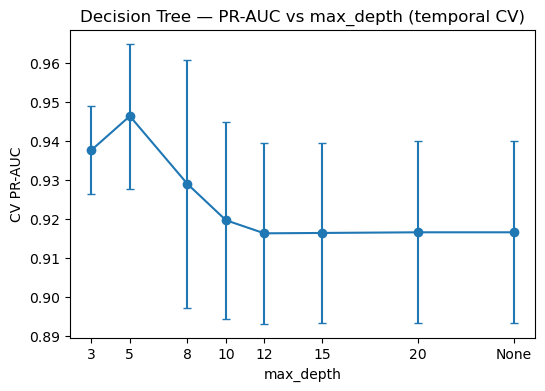

In [ ]:
depths = [3, 5, 8, 10, 12, 15, 20, None]
ap_means, ap_stds = [], []

for d in depths:
    clf = DecisionTreeClassifier(
        criterion="gini", max_depth=d, min_samples_leaf=10, min_samples_split=10,
        class_weight="balanced", random_state=42
    )
    # 5-fold CV on temporal TRAIN
    scores = cross_val_score(clf, X_train_temp, y_train_temp, cv=5,
                             scoring="average_precision", n_jobs=-1)
    ap_means.append(scores.mean()); ap_stds.append(scores.std())

x = [d if d is not None else 25 for d in depths]  # plot "None" at 25
plt.figure(figsize=(6,4))
plt.errorbar(x, ap_means, yerr=1.96*np.array(ap_stds), fmt='-o', capsize=3)
plt.xticks(x, [str(d) for d in depths]); plt.xlabel("max_depth"); plt.ylabel("CV PR-AUC")
plt.title("Decision Tree — PR-AUC vs max_depth (temporal CV)"); plt.show()


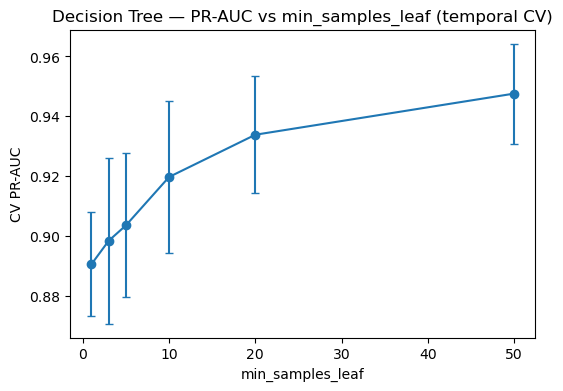

In [63]:
leaves = [1, 3, 5, 10, 20, 50]
ap_means, ap_stds = [], []
for m in leaves:
    clf = DecisionTreeClassifier(
        criterion="gini", max_depth=10, min_samples_leaf=m, min_samples_split=10,
        class_weight="balanced", random_state=42
    )
    scores = cross_val_score(clf, X_train_temp, y_train_temp, cv=5,
                             scoring="average_precision", n_jobs=-1)
    ap_means.append(scores.mean()); ap_stds.append(scores.std())

plt.figure(figsize=(6,4))
plt.errorbar(leaves, ap_means, yerr=1.96*np.array(ap_stds), fmt='-o', capsize=3)
plt.xlabel("min_samples_leaf"); plt.ylabel("CV PR-AUC")
plt.title("Decision Tree — PR-AUC vs min_samples_leaf (temporal CV)"); plt.show()


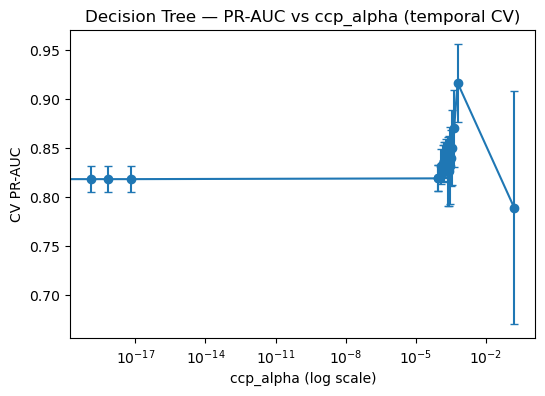

In [ ]:
path = DecisionTreeClassifier(random_state=42, class_weight="balanced").cost_complexity_pruning_path(X_train_temp, y_train_temp)
ccp_alphas = path.ccp_alphas[np.linspace(0, len(path.ccp_alphas)-1, 20, dtype=int)]  # 20 evenly spaced points

ap_means, ap_stds = [], []
for a in ccp_alphas:
    clf = DecisionTreeClassifier(
        criterion="gini", max_depth=None, min_samples_leaf=1, min_samples_split=2,
        class_weight="balanced", ccp_alpha=a, random_state=42
    )
    scores = cross_val_score(clf, X_train_temp, y_train_temp, cv=5,
                             scoring="average_precision", n_jobs=-1)
    ap_means.append(scores.mean()); ap_stds.append(scores.std())

plt.figure(figsize=(6,4))
plt.errorbar(ccp_alphas, ap_means, yerr=1.96*np.array(ap_stds), fmt='-o', capsize=3)
plt.xscale('log'); plt.xlabel("ccp_alpha (log scale)"); plt.ylabel("CV PR-AUC")
plt.title("Decision Tree — PR-AUC vs ccp_alpha (temporal CV)"); plt.show()


Random Forest (Temporal split):


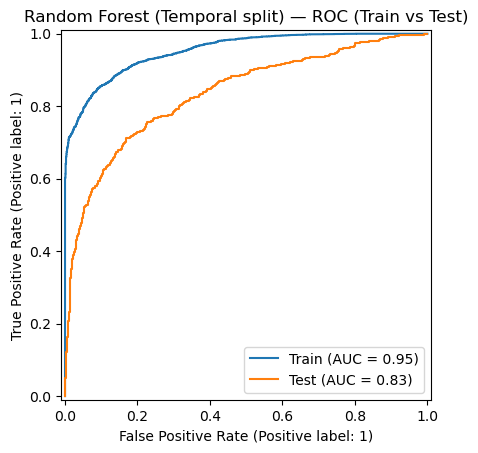

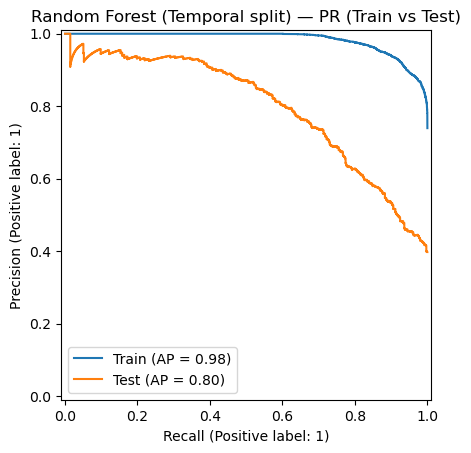


Random Forest (Temporal split) — Test — metrics @ t=0.500 | ROC-AUC=0.8346  PR-AUC=0.7985  MCC=0.5027  κ=0.4984
              precision    recall  f1-score   support

           0     0.8301    0.7421    0.7837      1047
           1     0.6633    0.7699    0.7127       691

    accuracy                         0.7532      1738
   macro avg     0.7467    0.7560    0.7482      1738
weighted avg     0.7638    0.7532    0.7554      1738



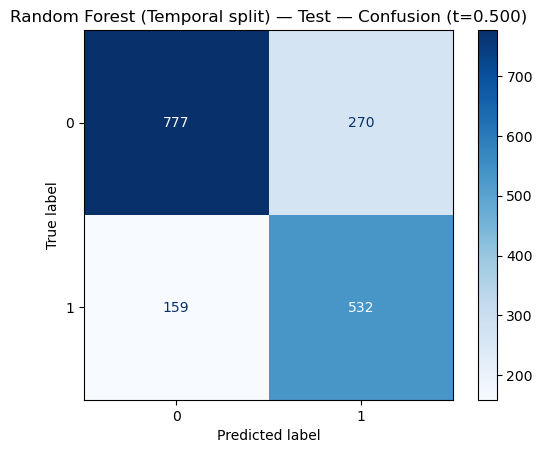

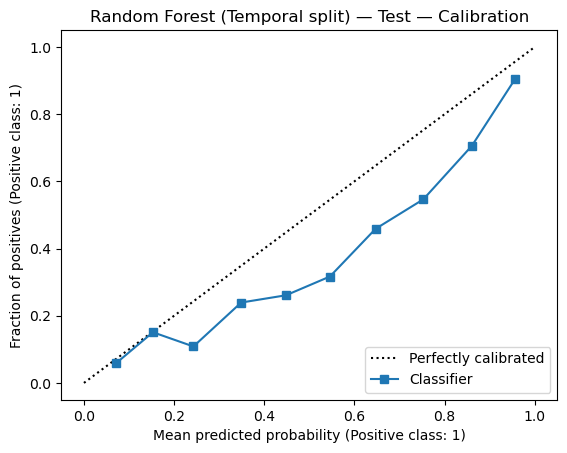

Random Forest (Temporal split): best-F1 on TRAIN → t=0.354, Precision=0.921, Recall=0.929, F1=0.925

Random Forest (Temporal split) — Train — metrics @ t=0.354 | ROC-AUC=0.9532  PR-AUC=0.9837  MCC=0.7072  κ=0.7071
              precision    recall  f1-score   support

           0     0.7926    0.7725    0.7824      1811
           1     0.9206    0.9288    0.9247      5141

    accuracy                         0.8881      6952
   macro avg     0.8566    0.8507    0.8536      6952
weighted avg     0.8872    0.8881    0.8876      6952



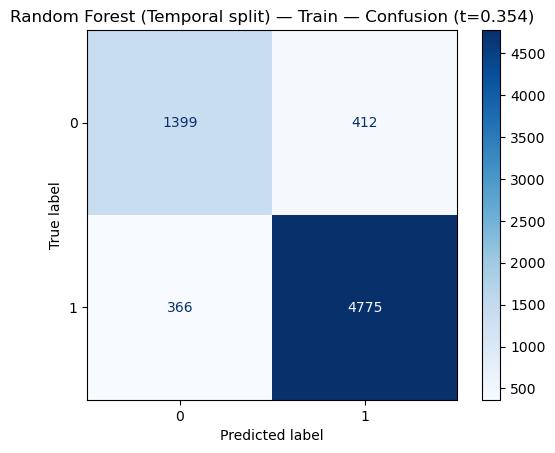

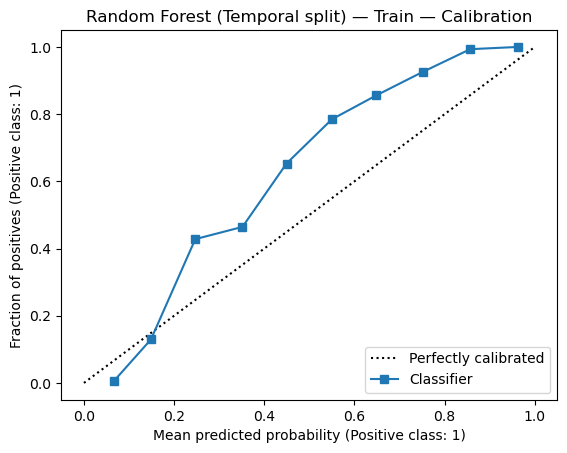


Random Forest (Temporal split) — Test — metrics @ t=0.354 | ROC-AUC=0.8346  PR-AUC=0.7985  MCC=0.4404  κ=0.4042
              precision    recall  f1-score   support

           0     0.8690    0.5702    0.6886      1047
           1     0.5718    0.8698    0.6900       691

    accuracy                         0.6893      1738
   macro avg     0.7204    0.7200    0.6893      1738
weighted avg     0.7509    0.6893    0.6891      1738



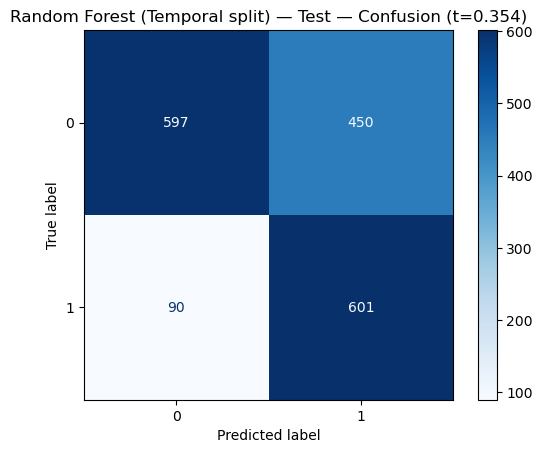

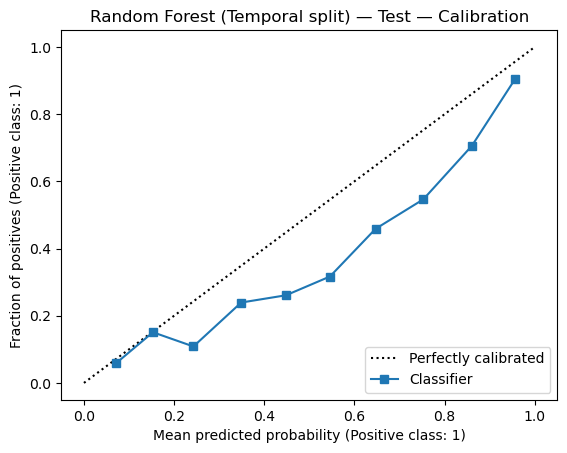

Random Forest (Random split):


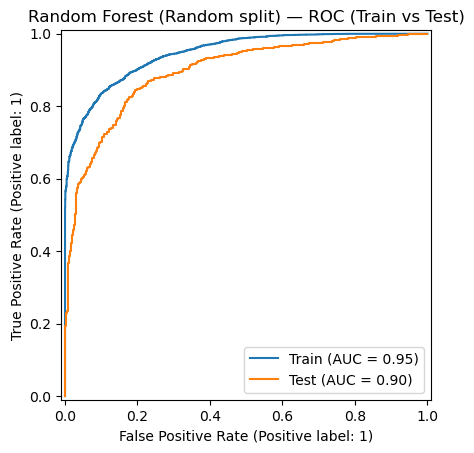

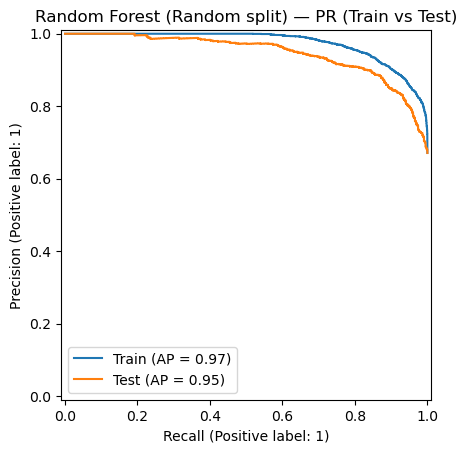


Random Forest (Random split) — Test — metrics @ t=0.500 | ROC-AUC=0.8960  PR-AUC=0.9467  MCC=0.6202  κ=0.6146
              precision    recall  f1-score   support

           0     0.6926    0.8234    0.7524       572
           1     0.9045    0.8208    0.8606      1166

    accuracy                         0.8216      1738
   macro avg     0.7986    0.8221    0.8065      1738
weighted avg     0.8348    0.8216    0.8250      1738



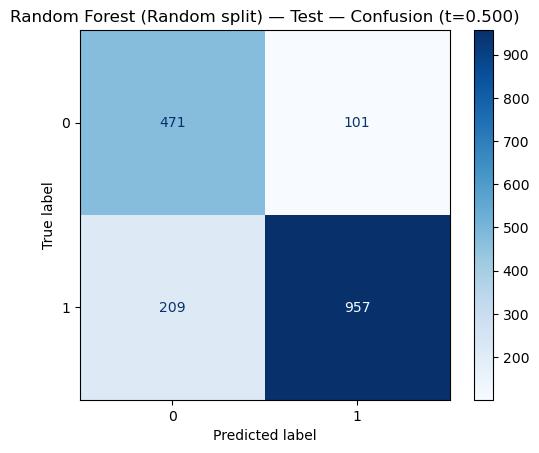

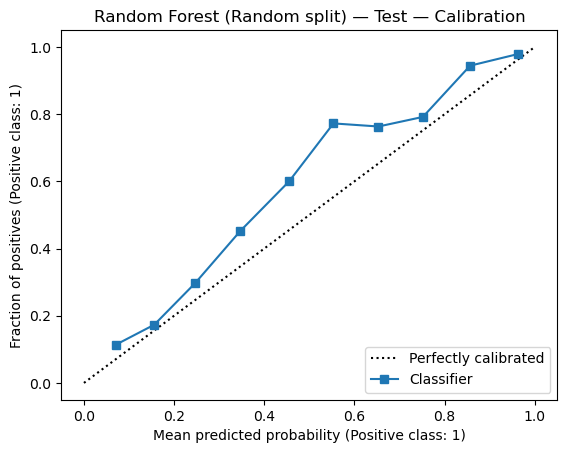

Random Forest (Random split): best-F1 on TRAIN → t=0.317, Precision=0.876, Recall=0.938, F1=0.906

Random Forest (Random split) — Train — metrics @ t=0.317 | ROC-AUC=0.9465  PR-AUC=0.9744  MCC=0.6968  κ=0.6926
              precision    recall  f1-score   support

           0     0.8515    0.7297    0.7859      2286
           1     0.8762    0.9376    0.9059      4666

    accuracy                         0.8692      6952
   macro avg     0.8638    0.8336    0.8459      6952
weighted avg     0.8681    0.8692    0.8664      6952



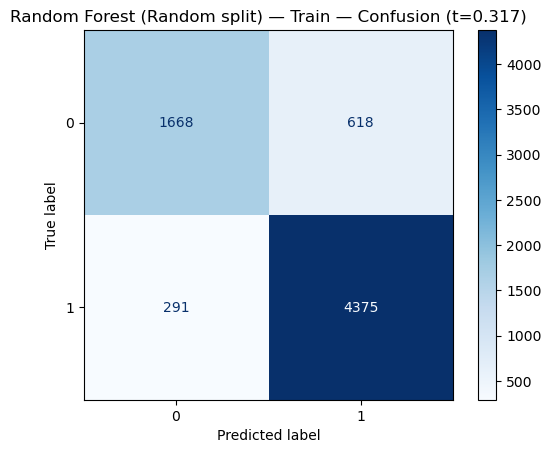

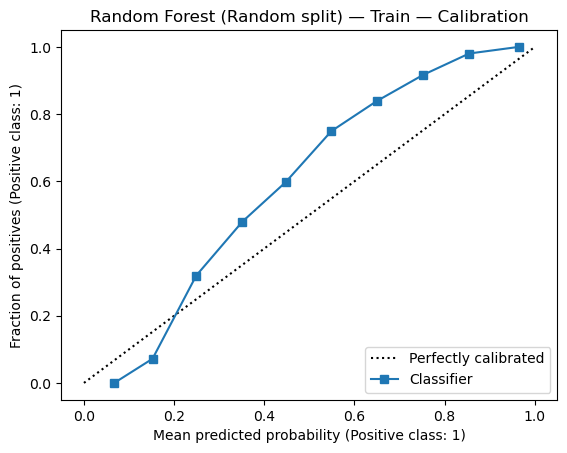


Random Forest (Random split) — Test — metrics @ t=0.317 | ROC-AUC=0.8960  PR-AUC=0.9467  MCC=0.5966  κ=0.5913
              precision    recall  f1-score   support

           0     0.7869    0.6521    0.7132       572
           1     0.8426    0.9134    0.8765      1166

    accuracy                         0.8274      1738
   macro avg     0.8147    0.7827    0.7949      1738
weighted avg     0.8243    0.8274    0.8228      1738



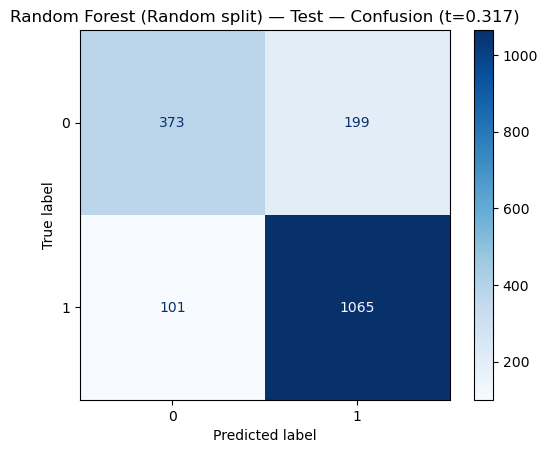

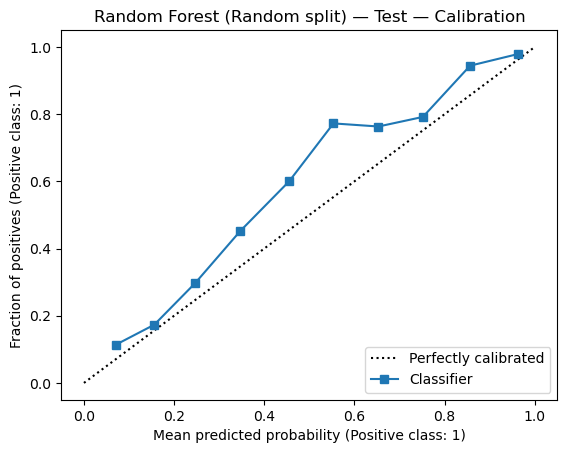

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=8,
    min_samples_split=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipe_rf = make_pipeline(rf_base)
pipe_rf.fit(X_train_temp, y_train_temp)

print("Random Forest (Temporal split):")
res_rf_temp = evaluate_train_test(
    pipe_rf, X_train_temp, y_train_temp, X_test_temp, y_test_temp,
    name="Random Forest (Temporal split)"
)

pipe_rf.fit(X_train_rand, y_train_rand)
print("Random Forest (Random split):")
res_rf_rand = evaluate_train_test(
    pipe_rf, X_train_rand, y_train_rand, X_test_rand, y_test_rand,
    name="Random Forest (Random split)"
)


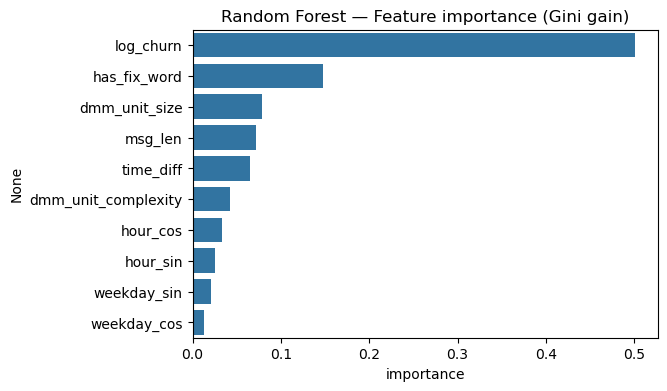

<Figure size 600x400 with 0 Axes>

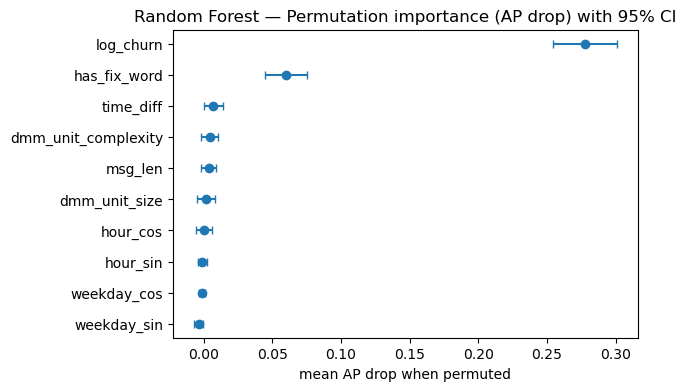

In [85]:
from sklearn.inspection import permutation_importance

rf_best = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=8,
    min_samples_split=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train_temp, y_train_temp)

# Gini importance
gini_imp = pd.Series(rf_best.feature_importances_, index=X_train_temp.columns).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=gini_imp.values[:12], y=gini_imp.index[:12])
plt.title("Random Forest — Feature importance (Gini gain)"); plt.xlabel("importance"); plt.show()

# Permutation importance
perm = permutation_importance(rf_best, X_test_temp, y_test_temp, n_repeats=30, random_state=42, scoring="average_precision")
perm_df = pd.DataFrame({
    "mean": perm.importances_mean,
    "std": perm.importances_std
}, index=X_test_temp.columns).sort_values("mean", ascending=False)

plt.figure(figsize=(6,4))
sub = perm_df.head(12) 
x = sub['mean'].values
xerr = 1.96 * sub['std'].values
y = np.arange(len(sub))

plt.figure(figsize=(6,4))
plt.errorbar(x, y, xerr=xerr, fmt='o', capsize=3)
plt.yticks(y, sub.index)
plt.title("Random Forest — Permutation importance (AP drop) with 95% CI")
plt.xlabel("mean AP drop when permuted")
plt.gca().invert_yaxis()
plt.show()


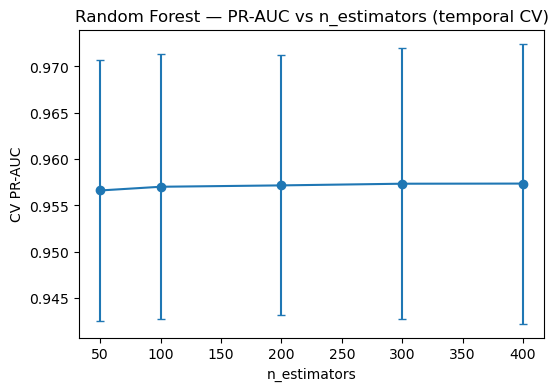

In [84]:
trees = [50, 100, 200, 300, 400]
ap_means, ap_stds = [], []
for n in trees:
    rf = RandomForestClassifier(
        n_estimators=n, max_depth=10,
        min_samples_leaf=10, min_samples_split=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    scores = cross_val_score(rf, X_train_temp, y_train_temp, cv=5, scoring="average_precision", n_jobs=-1)
    ap_means.append(scores.mean()); ap_stds.append(scores.std())

plt.figure(figsize=(6,4))
plt.errorbar(trees, ap_means, yerr=1.96*np.array(ap_stds), fmt='-o', capsize=3)
plt.xlabel("n_estimators"); plt.ylabel("CV PR-AUC")
plt.title("Random Forest — PR-AUC vs n_estimators (temporal CV)"); plt.show()


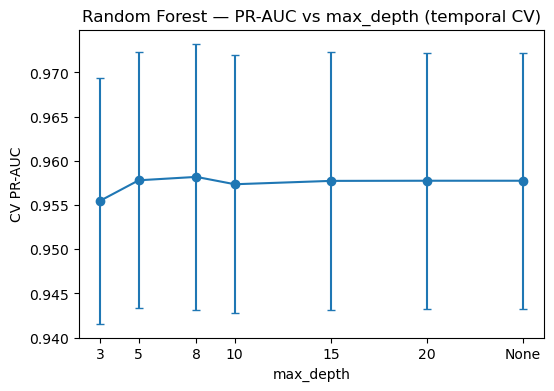

In [82]:
depths = [3, 5, 8, 10, 15, 20, None]
ap_means, ap_stds = [], []
for d in depths:
    rf = RandomForestClassifier(
        n_estimators=300, max_depth=d,
        min_samples_leaf=10, min_samples_split=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    scores = cross_val_score(rf, X_train_temp, y_train_temp, cv=5, scoring="average_precision", n_jobs=-1)
    ap_means.append(scores.mean()); ap_stds.append(scores.std())

x = [d if d is not None else 25 for d in depths]
plt.figure(figsize=(6,4))
plt.errorbar(x, ap_means, yerr=1.96*np.array(ap_stds), fmt='-o', capsize=3)
plt.xticks(x, [str(d) for d in depths]); plt.xlabel("max_depth"); plt.ylabel("CV PR-AUC")
plt.title("Random Forest — PR-AUC vs max_depth (temporal CV)"); plt.show()


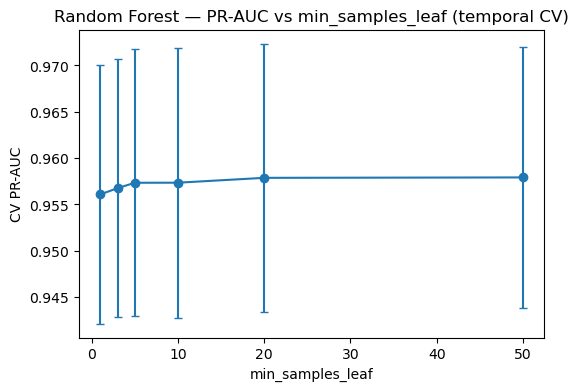

In [81]:
leaves = [1, 3, 5, 10, 20, 50]
ap_means, ap_stds = [], []
for m in leaves:
    rf = RandomForestClassifier(
        n_estimators=300, max_depth=10,
        min_samples_leaf=m, min_samples_split=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    scores = cross_val_score(rf, X_train_temp, y_train_temp, cv=5, scoring="average_precision", n_jobs=-1)
    ap_means.append(scores.mean()); ap_stds.append(scores.std())

plt.figure(figsize=(6,4))
plt.errorbar(leaves, ap_means, yerr=1.96*np.array(ap_stds), fmt='-o', capsize=3)
plt.xlabel("min_samples_leaf"); plt.ylabel("CV PR-AUC")
plt.title("Random Forest — PR-AUC vs min_samples_leaf (temporal CV)"); plt.show()
